# Deep Learning and Neural Networks: Assignment 3A

In [0]:
# import libraries
import tensorflow as tf
from tensorflow import keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
from six.moves import range

In [0]:
from google.colab import drive
drive.mount('/content/gdrive/')

model_path = "/content/gdrive/My Drive/DLNN/A3/Models/"
history_path = "/content/gdrive/My Drive/DLNN/A3/Histories/"
plot_path = "/content/gdrive/My Drive/DLNN/A3/Plots/"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [0]:
#create Character Table Class
class CharacterTable(object):
    """Given a set of characters:
    + Encode them to a one-hot integer representation
    + Decode the one-hot or integer representation to their character output
    + Decode a vector of probabilities to their character output
    """
    def __init__(self, chars):
        """Initialize character table.
        # Arguments
            chars: Characters that can appear in the input.
        """
        self.chars = sorted(set(chars))
        self.char_indices = dict((c, i) for i, c in enumerate(self.chars))
        self.indices_char = dict((i, c) for i, c in enumerate(self.chars))

    def encode(self, C, num_rows):
        """One-hot encode given string C.
        # Arguments
            C: string, to be encoded.
            num_rows: Number of rows in the returned one-hot encoding. This is
                used to keep the # of rows for each data the same.
        """
        x = np.zeros((num_rows, len(self.chars)))
        for i, c in enumerate(C):
            x[i, self.char_indices[c]] = 1
        return x

    def decode(self, x, calc_argmax=True):
        """Decode the given vector or 2D array to their character output.
        # Arguments
            x: A vector or a 2D array of probabilities or one-hot representations;
                or a vector of character indices (used with `calc_argmax=False`).
            calc_argmax: Whether to find the character index with maximum
                probability, defaults to `True`.
        """
        if calc_argmax:
            x = x.argmax(axis=-1)
        return ''.join(self.indices_char[x] for x in x)

## Helper functions

In [0]:
def generate_data(N, digits, as_pairs = False, reverse = False):
    TRAINING_SIZE = N
    DIGITS = digits
    REVERSE = reverse

    if as_pairs: # calculate integer sequence of pairs
        MAXLEN = DIGITS + DIGITS
        chars = '0123456789 '
        ctable = CharacterTable(chars)
        questions = []
        expected = []
        seen = set()
        print('Generating data...')
        while len(questions) < TRAINING_SIZE:
            f = lambda: int(''.join(np.random.choice(list('0123456789'))
                            for i in range(np.random.randint(1, DIGITS + 1))))
            a, b = f(), f()
            key = tuple(sorted((a, b)))
            if key in seen:
                continue
            seen.add(key)   
            ans = str(a + b) # calculate answer
            ans += ' ' * (DIGITS + 1 - len(ans))
            a,b = str(a),str(b)  # transform to string and concatenate as pairs
            a = (DIGITS - len(a)) * "0" + a
            b = (DIGITS - len(b)) * "0" + b
            query = ''.join([a[i] + b[i] for i in range(len(a))])
            if REVERSE:
                query = query[::-1]
            questions.append(query)
            expected.append(ans)
        print('Total addition questions:', len(questions))
        x = np.zeros((len(questions), MAXLEN, len(chars)), dtype=np.bool)
        y = np.zeros((len(questions), DIGITS + 1, len(chars)), dtype=np.bool)
        for i, sentence in enumerate(questions):
            x[i] = ctable.encode(sentence, MAXLEN)
        for i, sentence in enumerate(expected):
            y[i] = ctable.encode(sentence, DIGITS + 1)
        indices = np.arange(len(y)) # create random indices and shuffle data
        np.random.shuffle(indices)
        x = x[indices]
        y = y[indices]
        split_at = len(x) - len(x) // 10 # split data into train/val set 
        (x_train, x_val) = x[:split_at], x[split_at:]
        (y_train, y_val) = y[:split_at], y[split_at:]
        return x_train, x_val, y_train, y_val

    else: # calculate integer sequence
        MAXLEN = DIGITS + 1 + DIGITS
        chars = '0123456789+ '
        ctable = CharacterTable(chars)
        questions = []
        expected = []
        seen = set()
        print('Generating data...')
        while len(questions) < TRAINING_SIZE:
            f = lambda: int(''.join(np.random.choice(list('0123456789'))
                            for i in range(np.random.randint(1, DIGITS + 1))))
            a, b = f(), f()
            key = tuple(sorted((a, b)))
            if key in seen:
                continue
            seen.add(key)
            q = '{}+{}'.format(a, b)
            query = q + ' ' * (MAXLEN - len(q))
            ans = str(a + b)
            ans += ' ' * (DIGITS + 1 - len(ans))
            if REVERSE:
                query = query[::-1]
            questions.append(query)
            expected.append(ans)
        print('Total addition questions:', len(questions))
        x = np.zeros((len(questions), MAXLEN, len(chars)), dtype=np.bool)
        y = np.zeros((len(questions), DIGITS + 1, len(chars)), dtype=np.bool)
        for i, sentence in enumerate(questions):
            x[i] = ctable.encode(sentence, MAXLEN)
        for i, sentence in enumerate(expected):
            y[i] = ctable.encode(sentence, DIGITS + 1)
        indices = np.arange(len(y))
        np.random.shuffle(indices)
        x = x[indices]
        y = y[indices]
        split_at = len(x) - len(x) // 10
        (x_train, x_val) = x[:split_at], x[split_at:]
        (y_train, y_val) = y[:split_at], y[split_at:]

        return x_train, x_val, y_train, y_val

In [0]:
# generate data in bit representation
def generate_bit_data(N, digits, bits, as_pairs = False, reverse = False):
    TRAINING_SIZE = N
    DIGITS = digits
    BITS = bits
    REVERSE = reverse

    if as_pairs: # calculate pairs of bits
        chars = '01'
        ctable = CharacterTable(chars)
        MAXLEN = BITS + BITS
        questions = []
        expected = []
        seen = set()
        print('Generating data...')
        while len(questions) < TRAINING_SIZE:
            f = lambda: int(''.join(np.random.choice(list('0123456789'))
                            for i in range(np.random.randint(1, DIGITS + 1))))
            a, b = f(), f()
            key = tuple(sorted((a, b)))
            if key in seen:
                continue
            seen.add(key)
            ans = int(a + b) # compute answer
            ans = '{:011b}'.format(ans)
            a = '{:010b}'.format(a) # convert integer to bit representation
            b = '{:010b}'.format(b)
            query = ''.join([a[i] + b[i] for i in range(len(a))])
            if REVERSE:
                query = query[::-1]
            questions.append(query)
            expected.append(ans)
        print('Total addition questions:', len(questions))     
        x = np.zeros((len(questions), MAXLEN, len(chars)), dtype=np.bool)
        y = np.zeros((len(questions), BITS + 1, len(chars)), dtype=np.bool)
        for i, sentence in enumerate(questions):
            x[i] = ctable.encode(sentence, MAXLEN)
        for i, sentence in enumerate(expected):
            y[i] = ctable.encode(sentence, BITS + 1)
        indices = np.arange(len(y))
        np.random.shuffle(indices)
        x = x[indices]
        y = y[indices]
        split_at = len(x) - len(x) // 10
        (x_train, x_val) = x[:split_at], x[split_at:]
        (y_train, y_val) = y[:split_at], y[split_at:]
        return x_train, x_val, y_train, y_val
    
    else:  # calculate bits 
        chars = '01+'
        ctable = CharacterTable(chars)
        MAXLEN = BITS + 1 + BITS       
        questions = []
        expected = []
        seen = set()
        print('Generating data...')
        while len(questions) < TRAINING_SIZE:
            f = lambda: int(''.join(np.random.choice(list('0123456789'))
                            for i in range(np.random.randint(1, DIGITS + 1))))
            a, b = f(), f()
            key = tuple(sorted((a, b)))
            if key in seen:
                continue
            seen.add(key)
            ans = int(a + b) # compute answer
            ans = '{:011b}'.format(ans) # convert integer to bit representation
            a = '{:010b}'.format(a)
            b = '{:010b}'.format(b)
            query = '{}+{}'.format(a, b)
            if REVERSE:
                query = query[::-1]
            questions.append(query)
            expected.append(ans)
        print('Total addition questions:', len(questions))     
        x = np.zeros((len(questions), MAXLEN, len(chars)), dtype=np.bool)
        y = np.zeros((len(questions), BITS + 1, len(chars)), dtype=np.bool)
        for i, sentence in enumerate(questions):
            x[i] = ctable.encode(sentence, MAXLEN)
        for i, sentence in enumerate(expected):
            y[i] = ctable.encode(sentence, BITS + 1)
        indices = np.arange(len(y))
        np.random.shuffle(indices)
        x = x[indices]
        y = y[indices]
        split_at = len(x) - len(x) // 10
        (x_train, x_val) = x[:split_at], x[split_at:]
        (y_train, y_val) = y[:split_at], y[split_at:]
        return x_train, x_val, y_train, y_val

In [0]:
# create complete set 
def generate_complete_set(as_type = ("integer", "bit", "pairs", "bitpairs"), reverse = False):
    REVERSE = reverse
    BITS = 10
    DIGITS = 3
    if as_type == "bit": # calculate complete set as bit representation
        MAXLEN = BITS + 1 + BITS
        chars = "01+"
        ctable = CharacterTable(chars)
        allcomb = list(itertools.product(range(1023), range(1023)))
        questions = []
        answers = []
        for i in range(len(allcomb)):
            a, b = allcomb[i]
            ans = int(a + b)
            ans = '{:011b}'.format(ans)
            a = '{:010b}'.format(a)
            b = '{:010b}'.format(b)
            query = '{}+{}'.format(a, b)
            if REVERSE:
                query = query[::-1]
            questions.append(query)
            answers.append(ans)
        print('Total addition questions:', len(questions)) 
        x = np.zeros((len(questions), MAXLEN, len(chars)), dtype=np.bool)
        y = np.zeros((len(questions), BITS + 1, len(chars)), dtype=np.bool)
        for i, sentence in enumerate(questions):
            x[i] = ctable.encode(sentence, MAXLEN)
        for i, sentence in enumerate(answers):
            y[i] = ctable.encode(sentence, BITS + 1)  

    elif as_type == "integer": # calculate complete set as integer representation
        MAXLEN = DIGITS + 1 + DIGITS
        chars = '0123456789+ '
        ctable = CharacterTable(chars)
        allcomb = list(itertools.product(range(1000), range(1000)))
        questions = []
        answers = []
        for i in range(len(allcomb)):
            a, b = allcomb[i]
            q = '{}+{}'.format(a, b)
            query = q + ' ' * (MAXLEN - len(q))
            ans = str(a+b)
            ans += ' ' * (DIGITS + 1 - len(ans))
            if REVERSE:
                query = query[::-1]
            questions.append(query)
            answers.append(ans)  
        print('Total addition questions:', len(questions)) 
        x = np.zeros((len(questions), MAXLEN, len(chars)), dtype=np.bool)
        y = np.zeros((len(questions), DIGITS + 1, len(chars)), dtype=np.bool)
        for i, sentence in enumerate(questions):
            x[i] = ctable.encode(sentence, MAXLEN)
        for i, sentence in enumerate(answers):
            y[i] = ctable.encode(sentence, DIGITS + 1)  

    elif as_type == "pairs":    # calculate complete set as pairs of digits
        MAXLEN = DIGITS + DIGITS
        chars = '0123456789 '
        ctable = CharacterTable(chars)
        allcomb = list(itertools.product(range(1000), range(1000)))
        questions = []
        answers = []
        for i in range(len(allcomb)):
            a,b = allcomb[i]  
            ans = str(a + b) # calculate answer
            ans += ' ' * (DIGITS + 1 - len(ans))
            a,b = str(a),str(b) # transform to string and concatenate as pairs
            a = (DIGITS - len(a)) * "0" + a # concatenate zeros 
            b = (DIGITS - len(b)) * "0" + b
            query = ''.join([a[i] + b[i] for i in range(len(a))]) # create pairs
            if REVERSE:
                query = query[::-1]
            questions.append(query)
            answers.append(ans)
        print('Total addition questions:', len(questions)) 
        x = np.zeros((len(questions), MAXLEN, len(chars)), dtype=np.bool)
        y = np.zeros((len(questions), DIGITS + 1, len(chars)), dtype=np.bool)
        for i, sentence in enumerate(questions):
            x[i] = ctable.encode(sentence, MAXLEN)
        for i, sentence in enumerate(answers):
            y[i] = ctable.encode(sentence, DIGITS + 1)

    elif as_type == "bitpairs": # calculate pairs of bits
        MAXLEN = BITS + BITS
        chars = "01"
        ctable = CharacterTable(chars)
        allcomb = list(itertools.product(range(1023), range(1023)))
        questions = []
        answers = []
        for i in range(len(allcomb)):
            a, b = allcomb[i]
            ans = int(a + b)
            ans = '{:011b}'.format(ans)
            a = '{:010b}'.format(a)
            b = '{:010b}'.format(b)
            query = ''.join([a[i] + b[i] for i in range(len(a))])
            if REVERSE:
                query = query[::-1]
            questions.append(query)
            answers.append(ans)
        print('Total addition questions:', len(questions))  
        x = np.zeros((len(questions), MAXLEN, len(chars)), dtype=np.bool)
        y = np.zeros((len(questions), BITS + 1, len(chars)), dtype=np.bool)
        for i, sentence in enumerate(questions):
            x[i] = ctable.encode(sentence, MAXLEN)
        for i, sentence in enumerate(answers):
            y[i] = ctable.encode(sentence, BITS + 1)  
    return x,y

In [0]:
def ultimate_errors(model, x_tst, y_tst, as_bit = False):
    # get predicitions and decode
    preds_enc = np.argmax(model.predict(x_tst), axis = -1)
    preds_dec = [ctable.decode(preds_enc[i], calc_argmax=False) for i in range(len(y_tst))]

    true = [ctable.decode(y_tst[i]) for i in range(len(y_tst))]
    
    if as_bit: # decode true values and convert bit to int
        true_int = [int(true[i], 2) for i in range(len(true))]
        pred_int = [int(preds_dec[i], 2) for i in range(len(preds_dec))]

    else: # decode true values and convert str to integer
        true_int = [int(i.replace(" ", "")) for i in true]
        pred_int = [int(i.replace(" ", "")) for i in preds_dec]

    # accuracy
    correct = 0
    for i in range(len(y_tst)):
        if true_int[i] == pred_int[i]:
            correct += 1
    accuracy = correct / len(y_tst)

    # mse
    mse = np.sum(np.square(np.subtract(true_int, pred_int))) / len(y_tst)

    # mae
    mae = np.sum(np.absolute(np.subtract(true_int, pred_int))) / len(y_tst)

    return accuracy, mse, mae

# Task 1: Integer representation

In [0]:
#Set Data Parameters
TRAINING_SIZE = 5e4
DIGITS = 3
MAXLEN = DIGITS + 1 + DIGITS
chars = '0123456789+ '
ctable = CharacterTable(chars)

#Set Model Parameters
HIDDEN_SIZE = 128
BATCH_SIZE = 128
LAYERS = 1
histories_dict, results_dict = {}, {}

In [0]:
# generate data
# generate plain data
x_train_plain, x_val_plain, y_train_plain, y_val_plain = generate_data(TRAINING_SIZE, DIGITS, as_pairs = False, reverse = False)

# generate reverse data
x_train_rev, x_val_rev, y_train_rev, y_val_rev = generate_data(TRAINING_SIZE, DIGITS, as_pairs = False, reverse = True)

Generating data...
Total addition questions: 50000
Generating data...
Total addition questions: 50000


### Model: LSTM

In [0]:
# Try replacing GRU, or SimpleRNN.
RNN = layers.LSTM

# built the model
model = Sequential(name = "model_LSTM")
model.add(RNN(HIDDEN_SIZE, input_shape=(MAXLEN, len(chars))))
model.add(layers.RepeatVector(DIGITS + 1))
for _ in range(LAYERS):
    model.add(RNN(HIDDEN_SIZE, return_sequences=True))
model.add(layers.TimeDistributed(layers.Dense(len(chars), activation='softmax')))

# compile the model
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

Model: "model_LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 128)               72192     
_________________________________________________________________
repeat_vector (RepeatVector) (None, 4, 128)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 4, 128)            131584    
_________________________________________________________________
time_distributed (TimeDistri (None, 4, 12)             1548      
Total params: 205,324
Trainable params: 205,324
Non-trainable params: 0
_________________________________________________________________


#### Train on plain data

In [0]:
# train the model 
save_name = model.name + "_plain"

checkpoint_cb = keras.callbacks.ModelCheckpoint(model_path + save_name + ".h5",
                                                            save_best_only=True)

history = model.fit(x_train_plain, y_train_plain,
              batch_size=BATCH_SIZE,
              epochs=200,
              validation_data=(x_val_plain, y_val_plain),
              callbacks = [checkpoint_cb])

model.save(model_path + save_name + ".h5")

histories_dict["LSTM_plain"] = history

Epoch 1/200
352/352 [==============================] - 6s 18ms/step - loss: 1.8963 - accuracy: 0.3211 - val_loss: 1.8067 - val_accuracy: 0.3371
Epoch 2/200
352/352 [==============================] - 3s 9ms/step - loss: 1.7657 - accuracy: 0.3502 - val_loss: 1.7027 - val_accuracy: 0.3758
Epoch 3/200
352/352 [==============================] - 3s 9ms/step - loss: 1.6143 - accuracy: 0.3983 - val_loss: 1.5396 - val_accuracy: 0.4254
Epoch 4/200
352/352 [==============================] - 3s 9ms/step - loss: 1.4669 - accuracy: 0.4518 - val_loss: 1.3992 - val_accuracy: 0.4781
Epoch 5/200
352/352 [==============================] - 3s 9ms/step - loss: 1.3373 - accuracy: 0.5017 - val_loss: 1.2719 - val_accuracy: 0.5253
Epoch 6/200
352/352 [==============================] - 3s 10ms/step - loss: 1.2224 - accuracy: 0.5448 - val_loss: 1.1715 - val_accuracy: 0.5624
Epoch 7/200
352/352 [==============================] - 3s 9ms/step - loss: 1.1290 - accuracy: 0.5778 - val_loss: 1.0916 - val_accuracy: 0.59

In [0]:
# calculate ultimate errors
x_tst, y_tst = generate_complete_set(as_type = "integer", reverse = False)
score_lstm_plain = ultimate_errors(model, x_tst, y_tst)
results_dict["LSTM_plain"] = score_lstm_plain
print("Accuracy:", score_lstm_plain[0])
print("MSE:     ", score_lstm_plain[1])
print("MAE:     ", score_lstm_plain[2])

Total addition questions: 1000000
Accuracy: 0.991339
MSE:      18914.242756
MAE:      3.07431


#### Train on reverse data

In [0]:
# built the model again to start with new weights
model = Sequential(name = "model_LSTM")
model.add(RNN(HIDDEN_SIZE, input_shape=(MAXLEN, len(chars))))
model.add(layers.RepeatVector(DIGITS + 1))
for _ in range(LAYERS):
    model.add(RNN(HIDDEN_SIZE, return_sequences=True))
model.add(layers.TimeDistributed(layers.Dense(len(chars), activation='softmax')))

# compile the model
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [0]:
# train the model 
save_name = model.name + "_reverse"

checkpoint_cb = keras.callbacks.ModelCheckpoint(model_path + save_name + ".h5",
                                                            save_best_only=True)

history = model.fit(x_train_rev, y_train_rev,
              batch_size=BATCH_SIZE,
              epochs=200,
              validation_data=(x_val_rev, y_val_rev),
              callbacks = [checkpoint_cb])

model.save(model_path + save_name + ".h5")
        
# write history to file
pd.DataFrame(history.history).to_csv(history_path + save_name + ".csv")
histories_dict["LSTM_rev"] = history

Epoch 1/200
352/352 [==============================] - 5s 13ms/step - loss: 1.8746 - accuracy: 0.3244 - val_loss: 1.7861 - val_accuracy: 0.3429
Epoch 2/200
352/352 [==============================] - 3s 9ms/step - loss: 1.7220 - accuracy: 0.3638 - val_loss: 1.6543 - val_accuracy: 0.3869
Epoch 3/200
352/352 [==============================] - 3s 9ms/step - loss: 1.5744 - accuracy: 0.4099 - val_loss: 1.5057 - val_accuracy: 0.4354
Epoch 4/200
352/352 [==============================] - 3s 9ms/step - loss: 1.4304 - accuracy: 0.4639 - val_loss: 1.3541 - val_accuracy: 0.4924
Epoch 5/200
352/352 [==============================] - 3s 9ms/step - loss: 1.2837 - accuracy: 0.5210 - val_loss: 1.2251 - val_accuracy: 0.5463
Epoch 6/200
352/352 [==============================] - 3s 9ms/step - loss: 1.1733 - accuracy: 0.5646 - val_loss: 1.1316 - val_accuracy: 0.5818
Epoch 7/200
352/352 [==============================] - 3s 9ms/step - loss: 1.0804 - accuracy: 0.6016 - val_loss: 1.0497 - val_accuracy: 0.615

In [0]:
# calculate ultimate errors
x_tst,y_tst = generate_complete_set(as_type = "integer", reverse = True)
score_lstm_reverse = ultimate_errors(model, x_tst, y_tst)
results_dict["LSTM_rev"] = score_lstm_reverse
print("Accuracy:", score_lstm_reverse[0])
print("MSE:     ", score_lstm_reverse[1])
print("MAE:     ", score_lstm_reverse[2])

Total addition questions: 1000000
Accuracy: 0.998803
MSE:      2600.610196
MAE:      0.391244


### Model: SimpleRNN

In [0]:
RNN = layers.SimpleRNN 

# built the model
model = Sequential(name = "model_SimpleRNN")
model.add(RNN(HIDDEN_SIZE, input_shape=(MAXLEN, len(chars))))
model.add(layers.RepeatVector(DIGITS + 1))
for _ in range(LAYERS):
    model.add(RNN(HIDDEN_SIZE, return_sequences=True))
model.add(layers.TimeDistributed(layers.Dense(len(chars), activation='softmax')))

# compile the model
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

Model: "model_SimpleRNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 128)               18048     
_________________________________________________________________
repeat_vector_2 (RepeatVecto (None, 4, 128)            0         
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 4, 128)            32896     
_________________________________________________________________
time_distributed_2 (TimeDist (None, 4, 12)             1548      
Total params: 52,492
Trainable params: 52,492
Non-trainable params: 0
_________________________________________________________________


#### Train on plain data

In [0]:
# train the model 
save_name = model.name + "_plain"

checkpoint_cb = keras.callbacks.ModelCheckpoint(model_path + save_name + ".h5",
                                                            save_best_only=True)

history = model.fit(x_train_plain, y_train_plain,
              batch_size=BATCH_SIZE,
              epochs=200,
              validation_data=(x_val_plain, y_val_plain),
              callbacks = [checkpoint_cb])

model.save(model_path + save_name + ".h5")
        
# write history to file
pd.DataFrame(history.history).to_csv(history_path + save_name + ".csv")
histories_dict["SimpleRNN_plain"] = history


Epoch 1/200
352/352 [==============================] - 6s 18ms/step - loss: 1.6695 - accuracy: 0.3919 - val_loss: 1.5398 - val_accuracy: 0.4365
Epoch 2/200
352/352 [==============================] - 6s 16ms/step - loss: 1.4471 - accuracy: 0.4659 - val_loss: 1.3372 - val_accuracy: 0.5056
Epoch 3/200
352/352 [==============================] - 6s 16ms/step - loss: 1.2359 - accuracy: 0.5397 - val_loss: 1.1333 - val_accuracy: 0.5695
Epoch 4/200
352/352 [==============================] - 5s 15ms/step - loss: 1.0232 - accuracy: 0.6125 - val_loss: 0.9286 - val_accuracy: 0.6447
Epoch 5/200
352/352 [==============================] - 5s 15ms/step - loss: 0.8340 - accuracy: 0.6806 - val_loss: 0.7634 - val_accuracy: 0.7068
Epoch 6/200
352/352 [==============================] - 6s 16ms/step - loss: 0.6893 - accuracy: 0.7392 - val_loss: 0.6459 - val_accuracy: 0.7524
Epoch 7/200
352/352 [==============================] - 5s 16ms/step - loss: 0.5860 - accuracy: 0.7836 - val_loss: 0.5635 - val_accuracy:

In [0]:
# calculate ultimate errors
x_tst,y_tst = generate_complete_set(as_type = "integer", reverse = False)
score_simplernn_plain = ultimate_errors(model, x_tst, y_tst)
results_dict["SimpleRNN_plain"] = score_simplernn_plain
print("Accuracy:", score_simplernn_plain[0])
print("MSE:     ", score_simplernn_plain[1])
print("MAE:     ", score_simplernn_plain[2])

Total addition questions: 1000000
Accuracy: 0.839604
MSE:      82362.182305
MAE:      16.622965


#### Train on reverse data

In [0]:
# built the model to initialize new weights
model = Sequential(name = "model_SimpleRNN")
model.add(RNN(HIDDEN_SIZE, input_shape=(MAXLEN, len(chars))))
model.add(layers.RepeatVector(DIGITS + 1))
for _ in range(LAYERS):
    model.add(RNN(HIDDEN_SIZE, return_sequences=True))
model.add(layers.TimeDistributed(layers.Dense(len(chars), activation='softmax')))

# compile the model
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [0]:
# train the model 
save_name = model.name + "_reverse"

checkpoint_cb = keras.callbacks.ModelCheckpoint(model_path + save_name + ".h5",
                                                            save_best_only=True)

history = model.fit(x_train_rev, y_train_rev,
              batch_size=BATCH_SIZE,
              epochs=200,
              validation_data=(x_val_rev, y_val_rev),
              callbacks = [checkpoint_cb])

model.save(model_path + save_name + ".h5")
        
# write history to file
pd.DataFrame(history.history).to_csv(history_path + save_name + ".csv")
histories_dict["SimpleRNN_rev"] = history

Epoch 1/200
352/352 [==============================] - 7s 19ms/step - loss: 1.6766 - accuracy: 0.3927 - val_loss: 1.5605 - val_accuracy: 0.4245
Epoch 2/200
352/352 [==============================] - 6s 16ms/step - loss: 1.4627 - accuracy: 0.4564 - val_loss: 1.3694 - val_accuracy: 0.4843
Epoch 3/200
352/352 [==============================] - 6s 18ms/step - loss: 1.2207 - accuracy: 0.5321 - val_loss: 1.0942 - val_accuracy: 0.5759
Epoch 4/200
352/352 [==============================] - 6s 16ms/step - loss: 0.9455 - accuracy: 0.6345 - val_loss: 0.8464 - val_accuracy: 0.6791
Epoch 5/200
352/352 [==============================] - 6s 16ms/step - loss: 0.7436 - accuracy: 0.7162 - val_loss: 0.6727 - val_accuracy: 0.7487
Epoch 6/200
352/352 [==============================] - 6s 16ms/step - loss: 0.6076 - accuracy: 0.7755 - val_loss: 0.5892 - val_accuracy: 0.7764
Epoch 7/200
352/352 [==============================] - 6s 16ms/step - loss: 0.5106 - accuracy: 0.8187 - val_loss: 0.4900 - val_accuracy:

In [0]:
# calculate ultimate errors
x_tst,y_tst = generate_complete_set(as_type = "integer", reverse = True)
score_simplernn_reverse = ultimate_errors(model, x_tst, y_tst)
results_dict["SimpleRNN_rev"] = score_simplernn_reverse
print("Accuracy:", score_simplernn_reverse[0])
print("MSE:     ", score_simplernn_reverse[1])
print("MAE:     ", score_simplernn_reverse[2])

Total addition questions: 1000000
Accuracy: 0.957931
MSE:      15667.299186
MAE:      3.393186


### Model: GRU

In [0]:
RNN = layers.GRU

# built the model
model = Sequential(name = "model_GRU")
model.add(RNN(HIDDEN_SIZE, input_shape=(MAXLEN, len(chars))))
model.add(layers.RepeatVector(DIGITS + 1))
for _ in range(LAYERS):
    model.add(RNN(HIDDEN_SIZE, return_sequences=True))
model.add(layers.TimeDistributed(layers.Dense(len(chars), activation='softmax')))

# compile the model
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

Model: "model_GRU"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 128)               54528     
_________________________________________________________________
repeat_vector_4 (RepeatVecto (None, 4, 128)            0         
_________________________________________________________________
gru_1 (GRU)                  (None, 4, 128)            99072     
_________________________________________________________________
time_distributed_4 (TimeDist (None, 4, 12)             1548      
Total params: 155,148
Trainable params: 155,148
Non-trainable params: 0
_________________________________________________________________


#### Train on plain data

In [0]:
# train the model 
save_name = model.name + "_plain"

checkpoint_cb = keras.callbacks.ModelCheckpoint(model_path + save_name + ".h5",
                                                            save_best_only=True)

history = model.fit(x_train_plain, y_train_plain,
              batch_size=BATCH_SIZE,
              epochs=200,
              validation_data=(x_val_plain, y_val_plain),
              callbacks = [checkpoint_cb])

model.save(model_path + save_name + ".h5")
        
# write history to file
pd.DataFrame(history.history).to_csv(history_path + save_name + ".csv")
histories_dict["GRU_plain"] = history

Epoch 1/200
352/352 [==============================] - 4s 12ms/step - loss: 1.8582 - accuracy: 0.3281 - val_loss: 1.7544 - val_accuracy: 0.3478
Epoch 2/200
352/352 [==============================] - 3s 9ms/step - loss: 1.6388 - accuracy: 0.3853 - val_loss: 1.5176 - val_accuracy: 0.4279
Epoch 3/200
352/352 [==============================] - 3s 9ms/step - loss: 1.4163 - accuracy: 0.4674 - val_loss: 1.3284 - val_accuracy: 0.5046
Epoch 4/200
352/352 [==============================] - 3s 9ms/step - loss: 1.2854 - accuracy: 0.5190 - val_loss: 1.2547 - val_accuracy: 0.5301
Epoch 5/200
352/352 [==============================] - 3s 9ms/step - loss: 1.2163 - accuracy: 0.5438 - val_loss: 1.1985 - val_accuracy: 0.5494
Epoch 6/200
352/352 [==============================] - 3s 9ms/step - loss: 1.1685 - accuracy: 0.5588 - val_loss: 1.1364 - val_accuracy: 0.5723
Epoch 7/200
352/352 [==============================] - 3s 9ms/step - loss: 1.1070 - accuracy: 0.5827 - val_loss: 1.0676 - val_accuracy: 0.598

In [0]:
# calculate ultimate errors
x_tst,y_tst = generate_complete_set(as_type = "integer", reverse = False)
score_gru_plain = ultimate_errors(model, x_tst, y_tst)
results_dict["GRU_plain"] = score_gru_plain 
print("Accuracy:", score_gru_plain[0])
print("MSE:     ", score_gru_plain[1])
print("MAE:     ", score_gru_plain[2])

Total addition questions: 1000000
Accuracy: 0.986376
MSE:      34158.442414
MAE:      5.003188


#### Train on reverse data

In [0]:
# compile the model
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# train the model 
save_name = model.name + "_reverse"

checkpoint_cb = keras.callbacks.ModelCheckpoint(model_path + save_name + ".h5",
                                                            save_best_only=True)

history = model.fit(x_train_rev, y_train_rev,
              batch_size=BATCH_SIZE,
              epochs=200,
              validation_data=(x_val_rev, y_val_rev),
              callbacks = [checkpoint_cb])

model.save(model_path + save_name + ".h5")
        
# write history to file
pd.DataFrame(history.history).to_csv(history_path + save_name + ".csv")
histories_dict["GRU_rev"] = history

Epoch 1/200
352/352 [==============================] - 4s 13ms/step - loss: 2.8384 - accuracy: 0.3741 - val_loss: 1.7362 - val_accuracy: 0.4279
Epoch 2/200
352/352 [==============================] - 3s 9ms/step - loss: 1.4930 - accuracy: 0.4798 - val_loss: 1.2679 - val_accuracy: 0.5310
Epoch 3/200
352/352 [==============================] - 3s 9ms/step - loss: 1.1181 - accuracy: 0.5720 - val_loss: 0.9697 - val_accuracy: 0.6248
Epoch 4/200
352/352 [==============================] - 3s 9ms/step - loss: 0.8322 - accuracy: 0.6786 - val_loss: 0.7043 - val_accuracy: 0.7363
Epoch 5/200
352/352 [==============================] - 3s 9ms/step - loss: 0.5983 - accuracy: 0.7794 - val_loss: 0.5268 - val_accuracy: 0.8042
Epoch 6/200
352/352 [==============================] - 3s 9ms/step - loss: 0.4328 - accuracy: 0.8513 - val_loss: 0.3771 - val_accuracy: 0.8766
Epoch 7/200
352/352 [==============================] - 3s 9ms/step - loss: 0.3259 - accuracy: 0.8985 - val_loss: 0.3054 - val_accuracy: 0.904

In [0]:
# calculate ultimate errors
x_tst,y_tst = generate_complete_set(as_type = "integer", reverse = True)
score_gru_reverse = ultimate_errors(model, x_tst, y_tst)
results_dict["GRU_rev"] = score_gru_reverse 
print("Accuracy:", score_gru_reverse[0])
print("MSE:     ", score_gru_reverse[1])
print("MAE:     ", score_gru_reverse[2])

Total addition questions: 1000000
Accuracy: 0.995493
MSE:      5743.797206
MAE:      0.956928


## Results

In [0]:
#plot results
results_df = pd.DataFrame(results_dict,
                          index = ["ACC", "MSE", "MAE"])
print(results_df.to_latex(float_format="%.3f"))

\begin{tabular}{lrrrrrr}
\toprule
{} &  LSTM\_plain &  LSTM\_rev &  SimpleRNN\_plain &  SimpleRNN\_rev &  GRU\_plain &  GRU\_rev \\
\midrule
ACC &       0.991 &     0.999 &            0.840 &          0.958 &      0.986 &    0.995 \\
MSE &   18914.243 &  2600.610 &        82362.182 &      15667.299 &  34158.442 & 5743.797 \\
MAE &       3.074 &     0.391 &           16.623 &          3.393 &      5.003 &    0.957 \\
\bottomrule
\end{tabular}



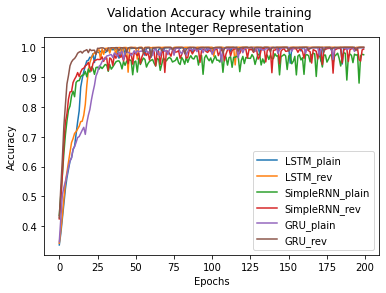

In [0]:
fig, ax = plt.subplots()
for key, item in histories_dict.items():
    plt.plot(pd.DataFrame(item.history["val_accuracy"]))

ax.set_xlabel("Epochs")
ax.set_ylabel("Accuracy")
plt.legend(histories_dict.keys())
plt.title("Validation Accuracy while training \n on the Integer Representation")
plt.show()

# Task 2: Bit representation

In [0]:
#Set data parameters
TRAINING_SIZE = 5e4
DIGITS, BITS = 3, 10
MAXLEN = BITS + 1 + BITS
chars = '01+'
ctable = CharacterTable(chars) #generate Character table for this encoding

#Set Model Parameters
HIDDEN_SIZE = 128
BATCH_SIZE = 128
LAYERS = 1
histories_dict, results_dict = {}, {}

#dictionaries to save results
histories_bits, results_bits = {}, {}

### Generate plain and reverse data

In [0]:
# generate plain data
x_train_plain, x_val_plain, y_train_plain, y_val_plain = generate_bit_data(TRAINING_SIZE, DIGITS, BITS, as_pairs = False, reverse = False)

# generate reverse data
x_train_rev, x_val_rev, y_train_rev, y_val_rev = generate_bit_data(TRAINING_SIZE, DIGITS, BITS, as_pairs = False, reverse = True)

Generating data...
Total addition questions: 50000
Generating data...
Total addition questions: 50000


### Model: LSTM

In [0]:
# Try replacing GRU, or SimpleRNN.
RNN = layers.LSTM

# built the model
model = Sequential(name = "model_LSTM_bit")
model.add(RNN(HIDDEN_SIZE, input_shape=(MAXLEN, len(chars))))
model.add(layers.RepeatVector(BITS + 1))
for _ in range(LAYERS):
    model.add(RNN(HIDDEN_SIZE, return_sequences=True))
model.add(layers.TimeDistributed(layers.Dense(len(chars), activation='softmax')))

# compile the model
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

Model: "model_LSTM_bit"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 128)               67584     
_________________________________________________________________
repeat_vector (RepeatVector) (None, 11, 128)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 11, 128)           131584    
_________________________________________________________________
time_distributed (TimeDistri (None, 11, 3)             387       
Total params: 199,555
Trainable params: 199,555
Non-trainable params: 0
_________________________________________________________________


##### Train on plain data

In [0]:
# train the model 
save_name = model.name + "_plain"

checkpoint_cb = keras.callbacks.ModelCheckpoint(model_path + save_name + ".h5",
                                                            save_best_only=True)

history = model.fit(x_train_plain, y_train_plain,
              batch_size=BATCH_SIZE,
              epochs=200,
              validation_data=(x_val_plain, y_val_plain),
              callbacks = [checkpoint_cb])

model.save(model_path + save_name + ".h5")
        
# write history to file
pd.DataFrame(history.history).to_csv(history_path + save_name + ".csv")
histories_bits["LSTM_plain"] = history

Epoch 1/200
352/352 [==============================] - 5s 14ms/step - loss: 0.6795 - accuracy: 0.5308 - val_loss: 0.6718 - val_accuracy: 0.5304
Epoch 2/200
352/352 [==============================] - 2s 6ms/step - loss: 0.6704 - accuracy: 0.5322 - val_loss: 0.6599 - val_accuracy: 0.5432
Epoch 3/200
352/352 [==============================] - 2s 6ms/step - loss: 0.6471 - accuracy: 0.5576 - val_loss: 0.6210 - val_accuracy: 0.5772
Epoch 4/200
352/352 [==============================] - 2s 6ms/step - loss: 0.5811 - accuracy: 0.6039 - val_loss: 0.5479 - val_accuracy: 0.6221
Epoch 5/200
352/352 [==============================] - 2s 6ms/step - loss: 0.5380 - accuracy: 0.6348 - val_loss: 0.5212 - val_accuracy: 0.6516
Epoch 6/200
352/352 [==============================] - 2s 6ms/step - loss: 0.5138 - accuracy: 0.6553 - val_loss: 0.4871 - val_accuracy: 0.6804
Epoch 7/200
352/352 [==============================] - 2s 6ms/step - loss: 0.4951 - accuracy: 0.6707 - val_loss: 0.4674 - val_accuracy: 0.687

In [0]:
# calculate ultimate errors
x_tst, y_tst = generate_complete_set(as_type = "bit", reverse = False)
score_lstm_bit_plain = ultimate_errors(model, x_tst, y_tst, as_bit = True)
results_bits["LSTM_plain"] = score_lstm_bit_plain
print("Accuracy:", score_lstm_bit_plain[0])
print("MSE:     ", score_lstm_bit_plain[1])
print("MAE:     ", score_lstm_bit_plain[2])

Total addition questions: 1046529
Accuracy: 0.8013738749714533
MSE:      777.5589897652144
MAE:      5.1541199527198955


##### Train on reverse data

In [0]:
# Try replacing GRU, or SimpleRNN.
RNN = layers.LSTM

# built the model
model = Sequential(name = "model_LSTM_bit")
model.add(RNN(HIDDEN_SIZE, input_shape=(MAXLEN, len(chars))))
model.add(layers.RepeatVector(BITS + 1))
for _ in range(LAYERS):
    model.add(RNN(HIDDEN_SIZE, return_sequences=True))
model.add(layers.TimeDistributed(layers.Dense(len(chars), activation='softmax')))

# compile the model
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

Model: "model_LSTM_bit"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 128)               67584     
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 11, 128)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 11, 128)           131584    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 11, 3)             387       
Total params: 199,555
Trainable params: 199,555
Non-trainable params: 0
_________________________________________________________________


In [0]:
# train the model 
save_name = model.name + "_reverse"

checkpoint_cb = keras.callbacks.ModelCheckpoint(model_path + save_name + ".h5",
                                                            save_best_only=True)

history = model.fit(x_train_rev, y_train_rev,
              batch_size=BATCH_SIZE,
              epochs=200,
              validation_data=(x_val_rev, y_val_rev),
              callbacks = [checkpoint_cb])

model.save(model_path + save_name + ".h5")
        
# write history to file
pd.DataFrame(history.history).to_csv(history_path + save_name + ".csv")
histories_bits["LSTM_rev"] = history

Epoch 1/200
352/352 [==============================] - 3s 9ms/step - loss: 0.6625 - accuracy: 0.5496 - val_loss: 0.6265 - val_accuracy: 0.5736
Epoch 2/200
352/352 [==============================] - 2s 6ms/step - loss: 0.6069 - accuracy: 0.5881 - val_loss: 0.5966 - val_accuracy: 0.5939
Epoch 3/200
352/352 [==============================] - 2s 6ms/step - loss: 0.5617 - accuracy: 0.6197 - val_loss: 0.5378 - val_accuracy: 0.6316
Epoch 4/200
352/352 [==============================] - 2s 6ms/step - loss: 0.5281 - accuracy: 0.6451 - val_loss: 0.5418 - val_accuracy: 0.6403
Epoch 5/200
352/352 [==============================] - 2s 6ms/step - loss: 0.5010 - accuracy: 0.6689 - val_loss: 0.4996 - val_accuracy: 0.6668
Epoch 6/200
352/352 [==============================] - 2s 6ms/step - loss: 0.4848 - accuracy: 0.6791 - val_loss: 0.4849 - val_accuracy: 0.6753
Epoch 7/200
352/352 [==============================] - 2s 6ms/step - loss: 0.4731 - accuracy: 0.6871 - val_loss: 0.4549 - val_accuracy: 0.6985

In [0]:
# calculate ultimate errors
x_tst, y_tst = generate_complete_set(as_type = "bit", reverse = True)
score_lstm_bit_rev = ultimate_errors(model, x_tst, y_tst, as_bit = True)
results_bits["LSTM_rev"] = score_lstm_bit_rev
print("Accuracy:", score_lstm_bit_rev[0])
print("MSE:     ", score_lstm_bit_rev[1])
print("MAE:     ", score_lstm_bit_rev[2])

Total addition questions: 1046529
Accuracy: 0.9993473663892735
MSE:      0.6925512814265061
MAE:      0.01821927533780717


### Model: SimpleRNN

In [0]:
# Try replacing GRU, or SimpleRNN.
RNN = layers.SimpleRNN

# built the model
model = Sequential(name = "model_SimpleRNN_bit")
model.add(RNN(HIDDEN_SIZE, input_shape=(MAXLEN, len(chars))))
model.add(layers.RepeatVector(BITS + 1))
for _ in range(LAYERS):
    model.add(RNN(HIDDEN_SIZE, return_sequences=True))
model.add(layers.TimeDistributed(layers.Dense(len(chars), activation='softmax')))

# compile the model
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

Model: "model_SimpleRNN_bit"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 128)               16896     
_________________________________________________________________
repeat_vector_2 (RepeatVecto (None, 11, 128)           0         
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 11, 128)           32896     
_________________________________________________________________
time_distributed_2 (TimeDist (None, 11, 3)             387       
Total params: 50,179
Trainable params: 50,179
Non-trainable params: 0
_________________________________________________________________


##### Train on plain data

In [0]:
# train the model 
save_name = model.name + "_plain"

checkpoint_cb = keras.callbacks.ModelCheckpoint(model_path + save_name + ".h5",
                                                            save_best_only=True)

history = model.fit(x_train_plain, y_train_plain,
              batch_size=BATCH_SIZE,
              epochs= 200,
              validation_data=(x_val_plain, y_val_plain),
              callbacks = [checkpoint_cb])

model.save(model_path + save_name + ".h5")
        
# write history to file
pd.DataFrame(history.history).to_csv(history_path + save_name + ".csv")
histories_bits["SimpleRNN_plain"] = history

Epoch 1/200
352/352 [==============================] - 8s 24ms/step - loss: 0.5633 - accuracy: 0.6477 - val_loss: 0.4416 - val_accuracy: 0.7557
Epoch 2/200
352/352 [==============================] - 7s 21ms/step - loss: 0.3469 - accuracy: 0.8213 - val_loss: 0.2357 - val_accuracy: 0.8975
Epoch 3/200
352/352 [==============================] - 8s 22ms/step - loss: 0.0960 - accuracy: 0.9642 - val_loss: 0.0230 - val_accuracy: 0.9939
Epoch 4/200
352/352 [==============================] - 8s 22ms/step - loss: 0.0180 - accuracy: 0.9951 - val_loss: 0.0124 - val_accuracy: 0.9968
Epoch 5/200
352/352 [==============================] - 7s 21ms/step - loss: 0.0078 - accuracy: 0.9980 - val_loss: 0.0060 - val_accuracy: 0.9986
Epoch 6/200
352/352 [==============================] - 8s 22ms/step - loss: 0.0111 - accuracy: 0.9970 - val_loss: 0.0025 - val_accuracy: 0.9996
Epoch 7/200
352/352 [==============================] - 8s 22ms/step - loss: 0.0047 - accuracy: 0.9988 - val_loss: 0.0017 - val_accuracy:

In [0]:
# calculate ultimate errors
x_tst, y_tst = generate_complete_set(as_type = "bit", reverse = False)
score_simplernn_bit_plain = ultimate_errors(model, x_tst, y_tst, as_bit = True)
results_bits["SimpleRNN_plain"] = score_simplernn_bit_plain
print("Accuracy:", score_simplernn_bit_plain[0])
print("MSE:     ", score_simplernn_bit_plain[1])
print("MAE:     ", score_simplernn_bit_plain[2])

Total addition questions: 1046529
Accuracy: 0.9991677249268773
MSE:      17.273538525927137
MAE:      0.06247414070704204


##### Train on reverse data

In [0]:
# built the model to initialize weights
model = Sequential(name = "model_SimpleRNN_bit")
model.add(RNN(HIDDEN_SIZE, input_shape=(MAXLEN, len(chars))))
model.add(layers.RepeatVector(BITS + 1))
for _ in range(LAYERS):
    model.add(RNN(HIDDEN_SIZE, return_sequences=True))
model.add(layers.TimeDistributed(layers.Dense(len(chars), activation='softmax')))

# compile the model
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [0]:
# train the model 
save_name = model.name + "_reverse"

checkpoint_cb = keras.callbacks.ModelCheckpoint(model_path + save_name + ".h5",
                                                            save_best_only=True)

history = model.fit(x_train_rev, y_train_rev,
              batch_size=BATCH_SIZE,
              epochs=200,
              validation_data=(x_val_rev, y_val_rev),
              callbacks = [checkpoint_cb])

model.save(model_path + save_name + ".h5")
        
# write history to file
pd.DataFrame(history.history).to_csv(history_path + save_name + ".csv")
histories_bits["SimpleRNN_rev"] = history

Epoch 1/200
352/352 [==============================] - 8s 23ms/step - loss: 0.5805 - accuracy: 0.6436 - val_loss: 0.4226 - val_accuracy: 0.7839
Epoch 2/200
352/352 [==============================] - 8s 22ms/step - loss: 0.1903 - accuracy: 0.9149 - val_loss: 0.0142 - val_accuracy: 0.9982
Epoch 3/200
352/352 [==============================] - 8s 22ms/step - loss: 0.0107 - accuracy: 0.9979 - val_loss: 0.0022 - val_accuracy: 0.9999
Epoch 4/200
352/352 [==============================] - 8s 22ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.0014 - val_accuracy: 0.9998
Epoch 5/200
352/352 [==============================] - 12s 33ms/step - loss: 6.3308e-04 - accuracy: 1.0000 - val_loss: 5.5327e-04 - val_accuracy: 1.0000
Epoch 6/200
352/352 [==============================] - 7s 21ms/step - loss: 0.0016 - accuracy: 0.9996 - val_loss: 0.4132 - val_accuracy: 0.9201
Epoch 7/200
352/352 [==============================] - 8s 21ms/step - loss: 0.0114 - accuracy: 0.9972 - val_loss: 5.8142e-04 - 

In [0]:
# calculate ultimate errors
x_tst, y_tst = generate_complete_set(as_type = "bit", reverse = True)
score_simplernn_bit_rev = ultimate_errors(model, x_tst, y_tst, as_bit = True)
results_bits["SimpleRNN_rev"] = score_simplernn_bit_rev
print("Accuracy:", score_simplernn_bit_rev[0])
print("MSE:     ", score_simplernn_bit_rev[1])
print("MAE:     ", score_simplernn_bit_rev[2])

Total addition questions: 1046529
Accuracy: 0.9999818447458216
MSE:      0.00014715311281388285
MAE:      4.013266713105896e-05


### Model: GRU


In [0]:
RNN = layers.GRU

# built the model
model = Sequential(name = "model_GRU_bit")
model.add(RNN(HIDDEN_SIZE, input_shape=(MAXLEN, len(chars))))
model.add(layers.RepeatVector(BITS + 1))
for _ in range(LAYERS):
    model.add(RNN(HIDDEN_SIZE, return_sequences=True))
model.add(layers.TimeDistributed(layers.Dense(len(chars), activation='softmax')))

# compile the model
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

Model: "model_GRU_bit"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 128)               51072     
_________________________________________________________________
repeat_vector_4 (RepeatVecto (None, 11, 128)           0         
_________________________________________________________________
gru_1 (GRU)                  (None, 11, 128)           99072     
_________________________________________________________________
time_distributed_4 (TimeDist (None, 11, 3)             387       
Total params: 150,531
Trainable params: 150,531
Non-trainable params: 0
_________________________________________________________________


##### Train on plain data

In [0]:
# train the model 
save_name = model.name + "_plain"

checkpoint_cb = keras.callbacks.ModelCheckpoint(model_path + save_name + ".h5",
                                                            save_best_only=True)

history = model.fit(x_train_plain, y_train_plain,
              batch_size=BATCH_SIZE,
              epochs=200,
              validation_data=(x_val_plain, y_val_plain),
              callbacks = [checkpoint_cb])

model.save(model_path + save_name + ".h5")
        
# write history to file
pd.DataFrame(history.history).to_csv(history_path + save_name + ".csv")
histories_bits["GRU_plain"] = history


Epoch 1/200
352/352 [==============================] - 3s 10ms/step - loss: 0.6743 - accuracy: 0.5366 - val_loss: 0.6425 - val_accuracy: 0.5717
Epoch 2/200
352/352 [==============================] - 2s 6ms/step - loss: 0.5828 - accuracy: 0.6019 - val_loss: 0.5413 - val_accuracy: 0.6266
Epoch 3/200
352/352 [==============================] - 2s 6ms/step - loss: 0.5223 - accuracy: 0.6463 - val_loss: 0.5137 - val_accuracy: 0.6567
Epoch 4/200
352/352 [==============================] - 2s 6ms/step - loss: 0.4891 - accuracy: 0.6755 - val_loss: 0.4993 - val_accuracy: 0.6642
Epoch 5/200
352/352 [==============================] - 2s 6ms/step - loss: 0.4587 - accuracy: 0.7000 - val_loss: 0.4366 - val_accuracy: 0.7126
Epoch 6/200
352/352 [==============================] - 2s 5ms/step - loss: 0.4346 - accuracy: 0.7169 - val_loss: 0.4075 - val_accuracy: 0.7337
Epoch 7/200
352/352 [==============================] - 2s 5ms/step - loss: 0.4238 - accuracy: 0.7253 - val_loss: 0.4224 - val_accuracy: 0.722

In [0]:
# calculate ultimate errors
x_tst,y_tst = generate_complete_set(as_type = "bit", reverse = False)
score_gru_bit_plain = ultimate_errors(model, x_tst, y_tst, as_bit = True)
results_bits["GRU_plain"] = score_gru_bit_plain
print("Accuracy:", score_gru_bit_plain[0])
print("MSE:     ", score_gru_bit_plain[1])
print("MAE:     ", score_gru_bit_plain[2])

Total addition questions: 1046529
Accuracy: 0.9845040127889433
MSE:      22.262810681787126
MAE:      0.3365726128946259


##### Train on reverse data

In [0]:
# compile the model
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# train the model 
save_name = model.name + "_reverse"

checkpoint_cb = keras.callbacks.ModelCheckpoint(model_path + save_name + ".h5",
                                                            save_best_only=True)

history = model.fit(x_train_rev, y_train_rev,
              batch_size=BATCH_SIZE,
              epochs=200,
              validation_data=(x_val_rev, y_val_rev),
              callbacks = [checkpoint_cb])

model.save(model_path + save_name + ".h5")
        
# write history to file
pd.DataFrame(history.history).to_csv(history_path + save_name + ".csv")
histories_bits["GRU_rev"] = history

Epoch 1/200
352/352 [==============================] - 3s 9ms/step - loss: 1.3862 - accuracy: 0.5735 - val_loss: 0.6227 - val_accuracy: 0.6263
Epoch 2/200
352/352 [==============================] - 2s 5ms/step - loss: 0.5373 - accuracy: 0.6663 - val_loss: 0.4904 - val_accuracy: 0.6915
Epoch 3/200
352/352 [==============================] - 2s 6ms/step - loss: 0.4555 - accuracy: 0.7096 - val_loss: 0.4375 - val_accuracy: 0.7214
Epoch 4/200
352/352 [==============================] - 2s 5ms/step - loss: 0.4137 - accuracy: 0.7368 - val_loss: 0.3895 - val_accuracy: 0.7535
Epoch 5/200
352/352 [==============================] - 2s 6ms/step - loss: 0.3730 - accuracy: 0.7644 - val_loss: 0.3737 - val_accuracy: 0.7649
Epoch 6/200
352/352 [==============================] - 2s 5ms/step - loss: 0.3508 - accuracy: 0.7793 - val_loss: 0.3431 - val_accuracy: 0.7874
Epoch 7/200
352/352 [==============================] - 2s 6ms/step - loss: 0.3336 - accuracy: 0.7919 - val_loss: 0.3216 - val_accuracy: 0.7990

In [0]:
# calculate ultimate errors
x_tst,y_tst = generate_complete_set(as_type = "bit", reverse = True)
score_gru_bit_reverse = ultimate_errors(model, x_tst, y_tst, as_bit = True)
results_bits["GRU_rev"] = score_gru_bit_reverse
print("Accuracy:", score_gru_bit_reverse[0])
print("MSE:     ", score_gru_bit_reverse[1])
print("MAE:     ", score_gru_bit_reverse[2])

Total addition questions: 1046529
Accuracy: 0.741636399946872
MSE:      948.5307602560464
MAE:      4.673903924305968


### Results

In [0]:
#Plot Results
results_df = pd.DataFrame(results_bits,
                          index = ["ACC", "MSE", "MAE"])
print(results_df.to_latex(float_format="%.3f"))

\begin{tabular}{lrrrrrr}
\toprule
{} &  LSTM\_plain &  LSTM\_rev &  SimpleRNN\_plain &  SimpleRNN\_rev &  GRU\_plain &  GRU\_rev \\
\midrule
ACC &       0.801 &     0.999 &            0.999 &          1.000 &      0.985 &    0.742 \\
MSE &     777.559 &     0.693 &           17.274 &          0.000 &     22.263 &  948.531 \\
MAE &       5.154 &     0.018 &            0.062 &          0.000 &      0.337 &    4.674 \\
\bottomrule
\end{tabular}



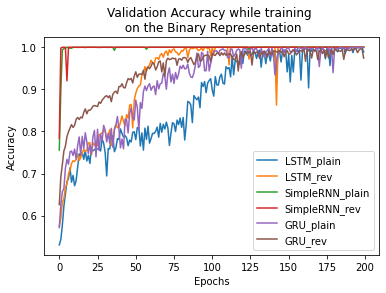

In [0]:
#Plot training
fig, ax = plt.subplots()
for key, item in histories_bits.items():
    plt.plot(pd.DataFrame(item.history["val_accuracy"]))

ax.set_xlabel("Epochs")
ax.set_ylabel("Accuracy")
plt.legend(histories_bits.keys())
plt.title("Validation Accuracy while training \n on the Binary Representation")
plt.show()

# Task 3: Pairs of digits

In [0]:
#data parameters
TRAINING_SIZE = 5e4
DIGITS = 3
MAXLEN = DIGITS + DIGITS
chars = '0123456789 '
ctable = CharacterTable(chars)

#empty dictionaries to save results
histories_digits_pairs, results_digits_pair = {}, {}

In [0]:
# generate plain data
x_train_plain, x_val_plain, y_train_plain, y_val_plain = generate_data(TRAINING_SIZE, DIGITS, as_pairs = True, reverse = False)

# generate reverse data
x_train_rev, x_val_rev, y_train_rev, y_val_rev = generate_data(TRAINING_SIZE, DIGITS, as_pairs = True, reverse = False)

Generating data...
Total addition questions: 50000
Generating data...
Total addition questions: 50000


#### Model: LSTM

In [0]:
RNN = layers.LSTM
HIDDEN_SIZE = 128
BATCH_SIZE = 128
LAYERS = 1

# built the model
model = Sequential(name = "model_LSTM_pairs")
model.add(RNN(HIDDEN_SIZE, input_shape=(MAXLEN, len(chars))))
model.add(layers.RepeatVector(DIGITS + 1))
for _ in range(LAYERS):
    model.add(RNN(HIDDEN_SIZE, return_sequences=True))
model.add(layers.TimeDistributed(layers.Dense(len(chars), activation='softmax')))

# compile the model
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

Model: "model_LSTM_pairs"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 128)               71680     
_________________________________________________________________
repeat_vector_5 (RepeatVecto (None, 4, 128)            0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 4, 128)            131584    
_________________________________________________________________
time_distributed_5 (TimeDist (None, 4, 11)             1419      
Total params: 204,683
Trainable params: 204,683
Non-trainable params: 0
_________________________________________________________________


##### Train on plain data

In [0]:
# train the model 
save_name = model.name + "_plain"

checkpoint_cb = keras.callbacks.ModelCheckpoint(model_path + save_name + ".h5",
                                                            save_best_only=True)

history = model.fit(x_train_plain, y_train_plain,
              batch_size=BATCH_SIZE,
              epochs=200,
              validation_data=(x_val_plain, y_val_plain),
              callbacks = [checkpoint_cb])

model.save(model_path + save_name + ".h5")
        
# write history to file
pd.DataFrame(history.history).to_csv(history_path + save_name + ".csv")

histories_digits_pairs["LSTM_plain"] = history

Epoch 1/200
352/352 [==============================] - 3s 8ms/step - loss: 1.8481 - accuracy: 0.3254 - val_loss: 1.6636 - val_accuracy: 0.3853
Epoch 2/200
352/352 [==============================] - 2s 5ms/step - loss: 1.5092 - accuracy: 0.4343 - val_loss: 1.3857 - val_accuracy: 0.4755
Epoch 3/200
352/352 [==============================] - 2s 5ms/step - loss: 1.3373 - accuracy: 0.4916 - val_loss: 1.2977 - val_accuracy: 0.5031
Epoch 4/200
352/352 [==============================] - 2s 5ms/step - loss: 1.2568 - accuracy: 0.5206 - val_loss: 1.2262 - val_accuracy: 0.5283
Epoch 5/200
352/352 [==============================] - 2s 5ms/step - loss: 1.1927 - accuracy: 0.5445 - val_loss: 1.1553 - val_accuracy: 0.5575
Epoch 6/200
352/352 [==============================] - 2s 5ms/step - loss: 1.1290 - accuracy: 0.5671 - val_loss: 1.0943 - val_accuracy: 0.5799
Epoch 7/200
352/352 [==============================] - 2s 5ms/step - loss: 1.0745 - accuracy: 0.5862 - val_loss: 1.0552 - val_accuracy: 0.5892

In [0]:
# calculate ultimate errors
x_tst, y_tst = generate_complete_set(as_type = "pairs", reverse = False)
score_lstm_pairs_plain = ultimate_errors(model, x_tst, y_tst, as_bit = False)
results_digits_pair["LSTM_plain"] = score_lstm_pairs_plain
print("Accuracy:", score_lstm_pairs_plain[0])
print("MSE:     ", score_lstm_pairs_plain[1])
print("MAE:     ", score_lstm_pairs_plain[2])

Total addition questions: 1000000
Accuracy: 0.998212
MSE:      4406.072874
MAE:      0.697234


##### Train on reverse data

In [0]:
RNN = layers.LSTM
HIDDEN_SIZE = 128
BATCH_SIZE = 128
LAYERS = 1

# built the model
model = Sequential(name = "model_LSTM_pairs")
model.add(RNN(HIDDEN_SIZE, input_shape=(MAXLEN, len(chars))))
model.add(layers.RepeatVector(DIGITS + 1))
for _ in range(LAYERS):
    model.add(RNN(HIDDEN_SIZE, return_sequences=True))
model.add(layers.TimeDistributed(layers.Dense(len(chars), activation='softmax')))

# compile the model
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

Model: "model_LSTM_pairs"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 128)               71680     
_________________________________________________________________
repeat_vector_6 (RepeatVecto (None, 4, 128)            0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 4, 128)            131584    
_________________________________________________________________
time_distributed_6 (TimeDist (None, 4, 11)             1419      
Total params: 204,683
Trainable params: 204,683
Non-trainable params: 0
_________________________________________________________________


In [0]:
# compile the model
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# train the model 
save_name = model.name + "_reverse"

checkpoint_cb = keras.callbacks.ModelCheckpoint(model_path + save_name + ".h5",
                                                            save_best_only=True)

history = model.fit(x_train_rev, y_train_rev,
              batch_size=BATCH_SIZE,
              epochs=200,
              validation_data=(x_val_rev, y_val_rev),
              callbacks = [checkpoint_cb])

model.save(model_path + save_name + ".h5")
        
# write history to file
pd.DataFrame(history.history).to_csv(history_path + save_name + ".csv")
histories_digits_pairs["LSTM_rev"] = history

Epoch 1/200
352/352 [==============================] - 3s 8ms/step - loss: 1.8279 - accuracy: 0.3344 - val_loss: 1.6205 - val_accuracy: 0.3970
Epoch 2/200
352/352 [==============================] - 2s 5ms/step - loss: 1.4807 - accuracy: 0.4461 - val_loss: 1.3701 - val_accuracy: 0.4821
Epoch 3/200
352/352 [==============================] - 2s 5ms/step - loss: 1.3244 - accuracy: 0.4994 - val_loss: 1.2856 - val_accuracy: 0.5106
Epoch 4/200
352/352 [==============================] - 2s 5ms/step - loss: 1.2519 - accuracy: 0.5264 - val_loss: 1.2246 - val_accuracy: 0.5310
Epoch 5/200
352/352 [==============================] - 2s 5ms/step - loss: 1.1825 - accuracy: 0.5498 - val_loss: 1.1481 - val_accuracy: 0.5564
Epoch 6/200
352/352 [==============================] - 2s 5ms/step - loss: 1.1176 - accuracy: 0.5691 - val_loss: 1.0863 - val_accuracy: 0.5805
Epoch 7/200
352/352 [==============================] - 2s 5ms/step - loss: 1.0621 - accuracy: 0.5890 - val_loss: 1.0402 - val_accuracy: 0.5960

In [0]:
# calculate ultimate errors
x_tst,y_tst = generate_complete_set(as_type = "pairs", reverse = True)
score_lstm_pairs_reverse = ultimate_errors(model, x_train_rev, y_train_rev, as_bit = False)
results_digits_pair["LSTM_rev"] = score_lstm_pairs_reverse
print("Accuracy:", score_lstm_pairs_reverse[0])
print("MSE:     ", score_lstm_pairs_reverse[1])
print("MAE:     ", score_lstm_pairs_reverse[2])

Total addition questions: 1000000
Accuracy: 0.9998888888888889
MSE:      0.0023777777777777777
MAE:      0.0003333333333333333


### Model: SimpleRNN

In [0]:
RNN = layers.SimpleRNN 
HIDDEN_SIZE = 128
BATCH_SIZE = 128
LAYERS = 1

# built the model
model = Sequential(name = "model_SimpleRNN_pairs")
model.add(RNN(HIDDEN_SIZE, input_shape=(MAXLEN, len(chars))))
model.add(layers.RepeatVector(DIGITS + 1))
for _ in range(LAYERS):
    model.add(RNN(HIDDEN_SIZE, return_sequences=True))
model.add(layers.TimeDistributed(layers.Dense(len(chars), activation='softmax')))

# compile the model
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

Model: "model_SimpleRNN_pairs"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_4 (SimpleRNN)     (None, 128)               17920     
_________________________________________________________________
repeat_vector_7 (RepeatVecto (None, 4, 128)            0         
_________________________________________________________________
simple_rnn_5 (SimpleRNN)     (None, 4, 128)            32896     
_________________________________________________________________
time_distributed_7 (TimeDist (None, 4, 11)             1419      
Total params: 52,235
Trainable params: 52,235
Non-trainable params: 0
_________________________________________________________________


##### Train on plain data

In [0]:
# train the model 
save_name = model.name + "_plain"

checkpoint_cb = keras.callbacks.ModelCheckpoint(model_path + save_name + ".h5",
                                                            save_best_only=True)

history = model.fit(x_train_plain, y_train_plain,
              batch_size=BATCH_SIZE,
              epochs=200,
              validation_data=(x_val_plain, y_val_plain),
              callbacks = [checkpoint_cb])

model.save(model_path + save_name + ".h5")

histories_digits_pairs["SimpleRNN_plain"] = history
# write history to file
pd.DataFrame(history.history).to_csv(history_path + save_name + ".csv")


Epoch 1/200
352/352 [==============================] - 4s 11ms/step - loss: 1.5694 - accuracy: 0.4204 - val_loss: 1.3651 - val_accuracy: 0.4884
Epoch 2/200
352/352 [==============================] - 3s 9ms/step - loss: 1.2499 - accuracy: 0.5391 - val_loss: 1.1269 - val_accuracy: 0.5816
Epoch 3/200
352/352 [==============================] - 3s 9ms/step - loss: 1.0231 - accuracy: 0.6218 - val_loss: 0.9476 - val_accuracy: 0.6539
Epoch 4/200
352/352 [==============================] - 3s 9ms/step - loss: 0.8785 - accuracy: 0.6777 - val_loss: 0.7898 - val_accuracy: 0.7034
Epoch 5/200
352/352 [==============================] - 3s 9ms/step - loss: 0.6256 - accuracy: 0.7723 - val_loss: 0.4973 - val_accuracy: 0.8281
Epoch 6/200
352/352 [==============================] - 3s 9ms/step - loss: 0.4183 - accuracy: 0.8667 - val_loss: 0.4013 - val_accuracy: 0.8588
Epoch 7/200
352/352 [==============================] - 3s 9ms/step - loss: 0.3087 - accuracy: 0.9108 - val_loss: 0.2557 - val_accuracy: 0.932

In [0]:
# calculate ultimate errors
x_tst,y_tst = generate_complete_set(as_type = "pairs", reverse = False)
score_simplernn_pairs_plain = ultimate_errors(model, x_tst, y_tst, as_bit = False)
results_digits_pair["SimpleRNN_plain"] = score_simplernn_pairs_plain
print("Accuracy:", score_simplernn_pairs_plain[0])
print("MSE:     ", score_simplernn_pairs_plain[1])
print("MAE:     ", score_simplernn_pairs_plain[2])

Total addition questions: 1000000
Accuracy: 0.996088
MSE:      981.009201
MAE:      0.331211


##### Train on reverse data

In [0]:
# rebuilt the model
model = Sequential(name = "model_SimpleRNN_pairs")
model.add(RNN(HIDDEN_SIZE, input_shape=(MAXLEN, len(chars))))
model.add(layers.RepeatVector(DIGITS + 1))
for _ in range(LAYERS):
    model.add(RNN(HIDDEN_SIZE, return_sequences=True))
model.add(layers.TimeDistributed(layers.Dense(len(chars), activation='softmax')))

# compile the model
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

Model: "model_SimpleRNN_pairs"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_6 (SimpleRNN)     (None, 128)               17920     
_________________________________________________________________
repeat_vector_8 (RepeatVecto (None, 4, 128)            0         
_________________________________________________________________
simple_rnn_7 (SimpleRNN)     (None, 4, 128)            32896     
_________________________________________________________________
time_distributed_8 (TimeDist (None, 4, 11)             1419      
Total params: 52,235
Trainable params: 52,235
Non-trainable params: 0
_________________________________________________________________


In [0]:
# train the model 
save_name = model.name + "_reverse"

checkpoint_cb = keras.callbacks.ModelCheckpoint(model_path + save_name + ".h5",
                                                            save_best_only=True)

history = model.fit(x_train_rev, y_train_rev,
              batch_size=BATCH_SIZE,
              epochs=200,
              validation_data=(x_val_rev, y_val_rev),
              callbacks = [checkpoint_cb])

model.save(model_path + save_name + ".h5")

histories_digits_pairs["SimpleRNN_rev"] = history
        
# write history to file
pd.DataFrame(history.history).to_csv(history_path + save_name + ".csv")

Epoch 1/200
352/352 [==============================] - 4s 11ms/step - loss: 1.5704 - accuracy: 0.4213 - val_loss: 1.3579 - val_accuracy: 0.4991
Epoch 2/200
352/352 [==============================] - 3s 9ms/step - loss: 1.2487 - accuracy: 0.5386 - val_loss: 1.1327 - val_accuracy: 0.5818
Epoch 3/200
352/352 [==============================] - 3s 9ms/step - loss: 1.0418 - accuracy: 0.6133 - val_loss: 0.9760 - val_accuracy: 0.6371
Epoch 4/200
352/352 [==============================] - 3s 9ms/step - loss: 0.9031 - accuracy: 0.6679 - val_loss: 0.8325 - val_accuracy: 0.6906
Epoch 5/200
352/352 [==============================] - 3s 9ms/step - loss: 0.6758 - accuracy: 0.7535 - val_loss: 0.5495 - val_accuracy: 0.7963
Epoch 6/200
352/352 [==============================] - 3s 9ms/step - loss: 0.4367 - accuracy: 0.8544 - val_loss: 0.3856 - val_accuracy: 0.8684
Epoch 7/200
352/352 [==============================] - 3s 9ms/step - loss: 0.3073 - accuracy: 0.9103 - val_loss: 0.2905 - val_accuracy: 0.905

In [0]:
# calculate ultimate errors
x_tst,y_tst = generate_complete_set(as_type = "pairs", reverse = True)
score_simplernn_pairs_reverse = ultimate_errors(model, x_val, y_val, as_bit = False)
results_digits_pair["SimpleRNN_rev"] = score_simplernn_pairs_reverse
print("Accuracy:", score_simplernn_pairs_reverse[0])
print("MSE:     ", score_simplernn_pairs_reverse[1])
print("MAE:     ", score_simplernn_pairs_reverse[2])

Total addition questions: 1000000
Accuracy: 0.065245
MSE:      330220.078216
MAE:      459.893404


### Model: GRU

In [0]:
RNN = layers.GRU
HIDDEN_SIZE = 128
BATCH_SIZE = 128
LAYERS = 1

# built the model
model = Sequential(name = "model_GRU_pairs")
model.add(RNN(HIDDEN_SIZE, input_shape=(MAXLEN, len(chars))))
model.add(layers.RepeatVector(DIGITS + 1))
for _ in range(LAYERS):
    model.add(RNN(HIDDEN_SIZE, return_sequences=True))
model.add(layers.TimeDistributed(layers.Dense(len(chars), activation='softmax')))

# comile the model
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

Model: "model_GRU_pairs"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_2 (GRU)                  (None, 128)               54144     
_________________________________________________________________
repeat_vector_9 (RepeatVecto (None, 4, 128)            0         
_________________________________________________________________
gru_3 (GRU)                  (None, 4, 128)            99072     
_________________________________________________________________
time_distributed_9 (TimeDist (None, 4, 11)             1419      
Total params: 154,635
Trainable params: 154,635
Non-trainable params: 0
_________________________________________________________________


#### Train on plain data

In [0]:
# train the model 
save_name = model.name + "_plain"

checkpoint_cb = keras.callbacks.ModelCheckpoint(model_path + save_name + ".h5",
                                                            save_best_only=True)

history = model.fit(x_train_plain, y_train_plain,
              batch_size=BATCH_SIZE,
              epochs=200,
              validation_data=(x_val_plain, y_val_plain),
              callbacks = [checkpoint_cb])

model.save(model_path + save_name + ".h5")
        
# write history to file
pd.DataFrame(history.history).to_csv(history_path + save_name + ".csv")
histories_digits_pairs["GRU_plain"] = history


Epoch 1/200
352/352 [==============================] - 3s 8ms/step - loss: 1.8077 - accuracy: 0.3380 - val_loss: 1.6442 - val_accuracy: 0.3889
Epoch 2/200
352/352 [==============================] - 2s 5ms/step - loss: 1.5077 - accuracy: 0.4370 - val_loss: 1.4351 - val_accuracy: 0.4530
Epoch 3/200
352/352 [==============================] - 2s 5ms/step - loss: 1.3456 - accuracy: 0.4892 - val_loss: 1.3180 - val_accuracy: 0.5049
Epoch 4/200
352/352 [==============================] - 2s 5ms/step - loss: 1.2853 - accuracy: 0.5084 - val_loss: 1.2609 - val_accuracy: 0.5178
Epoch 5/200
352/352 [==============================] - 2s 5ms/step - loss: 1.2377 - accuracy: 0.5268 - val_loss: 1.2133 - val_accuracy: 0.5371
Epoch 6/200
352/352 [==============================] - 2s 5ms/step - loss: 1.1997 - accuracy: 0.5412 - val_loss: 1.1665 - val_accuracy: 0.5555
Epoch 7/200
352/352 [==============================] - 2s 5ms/step - loss: 1.1547 - accuracy: 0.5579 - val_loss: 1.1287 - val_accuracy: 0.5703

In [0]:
# calculate ultimate errors
x_tst,y_tst = generate_complete_set(as_type = "pairs", reverse = False)
score_gru_pairs_plain = ultimate_errors(model, x_train_rev, y_train_rev, as_bit = False)
results_digits_pair["GRU_plain"] = score_gru_pairs_plain

print("Accuracy:", score_gru_pairs_plain[0])
print("MSE:     ", score_gru_pairs_plain[1])
print("MAE:     ", score_gru_pairs_plain[2])

Total addition questions: 1000000
Accuracy: 0.9602
MSE:      4720.947955555555
MAE:      1.238


In [0]:
# rebuilt the model
model = Sequential(name = "model_GRU_pairs")
model.add(RNN(HIDDEN_SIZE, input_shape=(MAXLEN, len(chars))))
model.add(layers.RepeatVector(DIGITS + 1))
for _ in range(LAYERS):
    model.add(RNN(HIDDEN_SIZE, return_sequences=True))
model.add(layers.TimeDistributed(layers.Dense(len(chars), activation='softmax')))

# comile the model
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

#### Train on reverse data

In [0]:
# train the model 
save_name = model.name + "_reverse"

checkpoint_cb = keras.callbacks.ModelCheckpoint(model_path + save_name + ".h5",
                                                            save_best_only=True)

history = model.fit(x_train_rev, y_train_rev,
              batch_size=BATCH_SIZE,
              epochs=200,
              validation_data=(x_val_rev, y_val_rev),
              callbacks = [checkpoint_cb])

model.save(model_path + save_name + ".h5")
        
# write history to file
pd.DataFrame(history.history).to_csv(history_path + save_name + ".csv")
histories_digits_pairs["GRU_rev"] = history

Epoch 1/200
352/352 [==============================] - 3s 8ms/step - loss: 1.8093 - accuracy: 0.3356 - val_loss: 1.6538 - val_accuracy: 0.3768
Epoch 2/200
352/352 [==============================] - 2s 5ms/step - loss: 1.4888 - accuracy: 0.4376 - val_loss: 1.3849 - val_accuracy: 0.4724
Epoch 3/200
352/352 [==============================] - 2s 5ms/step - loss: 1.3439 - accuracy: 0.4859 - val_loss: 1.3175 - val_accuracy: 0.4956
Epoch 4/200
352/352 [==============================] - 2s 5ms/step - loss: 1.2839 - accuracy: 0.5080 - val_loss: 1.2520 - val_accuracy: 0.5251
Epoch 5/200
352/352 [==============================] - 2s 5ms/step - loss: 1.2333 - accuracy: 0.5274 - val_loss: 1.2312 - val_accuracy: 0.5278
Epoch 6/200
352/352 [==============================] - 2s 5ms/step - loss: 1.1843 - accuracy: 0.5471 - val_loss: 1.1505 - val_accuracy: 0.5598
Epoch 7/200
352/352 [==============================] - 2s 5ms/step - loss: 1.1299 - accuracy: 0.5664 - val_loss: 1.0911 - val_accuracy: 0.5799

In [0]:
# calculate ultimate errors
x_tst,y_tst = generate_complete_set(as_type = "pairs", reverse = True)
score_gru_pairs_reverse = ultimate_errors(model, x_train_rev, y_train_rev, as_bit = False)
results_digits_pair["GRU_rev"] = score_gru_pairs_reverse
print("Accuracy:", score_gru_pairs_reverse[0])
print("MSE:     ", score_gru_pairs_reverse[1])
print("MAE:     ", score_gru_pairs_reverse[2])

Total addition questions: 1000000
Accuracy: 0.9999555555555556
MSE:      0.4444444444444444
MAE:      0.0044444444444444444


## Results

In [0]:
#Show results
results_df = pd.DataFrame(results_digits_pair,
                          index = ["ACC", "MSE", "MAE"])
print(results_df.to_latex(float_format="%.3f"))

\begin{tabular}{lrrrrrr}
\toprule
{} &  LSTM\_plain &  LSTM\_rev &  SimpleRNN\_plain &  SimpleRNN\_rev &  GRU\_plain &  GRU\_rev \\
\midrule
ACC &       0.998 &     1.000 &            0.996 &          0.065 &      0.960 &    1.000 \\
MSE &    4406.073 &     0.002 &          981.009 &     330220.078 &   4720.948 &    0.444 \\
MAE &       0.697 &     0.000 &            0.331 &        459.893 &      1.238 &    0.004 \\
\bottomrule
\end{tabular}



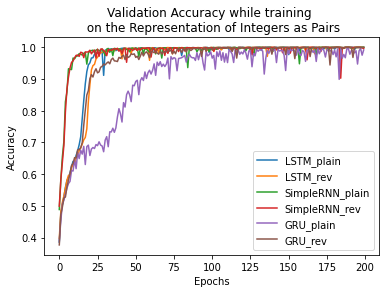

In [0]:
#plot training
fig, ax = plt.subplots()
for key, item in histories_digits_pairs.items():
    plt.plot(pd.DataFrame(item.history["val_accuracy"]))

ax.set_xlabel("Epochs")
ax.set_ylabel("Accuracy")
plt.legend(histories_digits_pairs.keys())
plt.title("Validation Accuracy while training \n on the Representation of Integers as Pairs")
plt.show()

# Task 4: Pairs of bits

In [0]:
TRAINING_SIZE = 5e4
DIGITS = 3
BITS = 10
MAXLEN = BITS + BITS
chars = '01'
ctable = CharacterTable(chars)

results_bit_pairs, histories_bit_pairs = {}, {}

In [0]:
# generate plain data
x_train_plain, x_val_plain, y_train_plain, y_val_plain = generate_bit_data(TRAINING_SIZE, DIGITS, BITS, as_pairs = True, reverse = False)

# generate reverse data
x_train_rev, x_val_rev, y_train_rev, y_val_rev = generate_bit_data(TRAINING_SIZE, DIGITS, BITS, as_pairs = True, reverse = True)

Generating data...
Total addition questions: 50000
Generating data...
Total addition questions: 50000


### Model: LSTM 

In [0]:
RNN = layers.LSTM
HIDDEN_SIZE = 128
BATCH_SIZE = 128
LAYERS = 1

# built the model
model = Sequential(name = "model_LSTM_bit_pairs")
model.add(RNN(HIDDEN_SIZE, input_shape=(MAXLEN, len(chars))))
model.add(layers.RepeatVector(BITS + 1))
for _ in range(LAYERS):
    model.add(RNN(HIDDEN_SIZE, return_sequences=True))
model.add(layers.TimeDistributed(layers.Dense(len(chars), activation='softmax')))

# compile the model
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

Model: "model_LSTM_bit_pairs"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 128)               67072     
_________________________________________________________________
repeat_vector (RepeatVector) (None, 11, 128)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 11, 128)           131584    
_________________________________________________________________
time_distributed (TimeDistri (None, 11, 2)             258       
Total params: 198,914
Trainable params: 198,914
Non-trainable params: 0
_________________________________________________________________


##### Train on plain data

In [0]:
# train the model 
save_name = model.name + "_plain"

checkpoint_cb = keras.callbacks.ModelCheckpoint(model_path + save_name + ".h5",
                                                            save_best_only=True)

history = model.fit(x_train_plain, y_train_plain,
              batch_size=BATCH_SIZE,
              epochs=200,
              validation_data=(x_val_plain, y_val_plain),
              callbacks = [checkpoint_cb])

model.save(model_path + save_name + ".h5")

histories_bit_pairs["LSTM_plain"] = history
        
# write history to file
pd.DataFrame(history.history).to_csv(history_path + save_name + ".csv")

Epoch 1/200
352/352 [==============================] - 9s 27ms/step - loss: 0.6011 - accuracy: 0.5928 - val_loss: 0.5422 - val_accuracy: 0.6364
Epoch 2/200
352/352 [==============================] - 5s 15ms/step - loss: 0.5255 - accuracy: 0.6519 - val_loss: 0.4986 - val_accuracy: 0.6747
Epoch 3/200
352/352 [==============================] - 5s 15ms/step - loss: 0.4959 - accuracy: 0.6722 - val_loss: 0.4938 - val_accuracy: 0.6744
Epoch 4/200
352/352 [==============================] - 5s 15ms/step - loss: 0.4840 - accuracy: 0.6818 - val_loss: 0.4614 - val_accuracy: 0.6957
Epoch 5/200
352/352 [==============================] - 5s 15ms/step - loss: 0.4707 - accuracy: 0.6915 - val_loss: 0.4612 - val_accuracy: 0.6964
Epoch 6/200
352/352 [==============================] - 5s 15ms/step - loss: 0.4583 - accuracy: 0.6992 - val_loss: 0.4539 - val_accuracy: 0.7002
Epoch 7/200
352/352 [==============================] - 5s 15ms/step - loss: 0.4488 - accuracy: 0.7076 - val_loss: 0.4423 - val_accuracy:

In [0]:
# calculate ultimate errors
x_tst, y_tst = generate_complete_set(as_type = "bitpairs", reverse = False)
score_lstm_bitpairs_plain = ultimate_errors(model, x_tst, y_tst, as_bit = True)
results_bit_pairs["LSTM_plain"] = score_lstm_bitpairs_plain
print("Accuracy:", score_lstm_bitpairs_plain[0])
print("MSE:     ", score_lstm_bitpairs_plain[1])
print("MAE:     ", score_lstm_bitpairs_plain[2])

Total addition questions: 1046529
Accuracy: 0.9872034124233537
MSE:      15.382470050997153
MAE:      0.26811583816597534


##### Train on reverse data

In [0]:
# built the model again to initialize weights
model = Sequential(name = "model_LSTM_bit_pairs")
model.add(RNN(HIDDEN_SIZE, input_shape=(MAXLEN, len(chars))))
model.add(layers.RepeatVector(BITS + 1))
for _ in range(LAYERS):
    model.add(RNN(HIDDEN_SIZE, return_sequences=True))
model.add(layers.TimeDistributed(layers.Dense(len(chars), activation='softmax')))

# compile the model
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

Model: "model_LSTM_bit_pairs"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 128)               67072     
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 11, 128)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 11, 128)           131584    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 11, 2)             258       
Total params: 198,914
Trainable params: 198,914
Non-trainable params: 0
_________________________________________________________________


In [0]:
# compile the model
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# train the model 
save_name = model.name + "_reverse"

checkpoint_cb = keras.callbacks.ModelCheckpoint(model_path + save_name + ".h5",
                                                            save_best_only=True)

history = model.fit(x_train_rev, y_train_rev,
              batch_size=BATCH_SIZE,
              epochs=200,
              validation_data=(x_val_rev, y_val_rev),
              callbacks = [checkpoint_cb])

model.save(model_path + save_name + ".h5")
        
# write history to file
pd.DataFrame(history.history).to_csv(history_path + save_name + ".csv")
histories_bit_pairs["LSTM_rev"] = history

Epoch 1/200
352/352 [==============================] - 7s 20ms/step - loss: 0.5549 - accuracy: 0.6500 - val_loss: 0.4401 - val_accuracy: 0.7481
Epoch 2/200
352/352 [==============================] - 5s 15ms/step - loss: 0.3575 - accuracy: 0.8083 - val_loss: 0.2673 - val_accuracy: 0.8672
Epoch 3/200
352/352 [==============================] - 5s 15ms/step - loss: 0.2140 - accuracy: 0.8968 - val_loss: 0.1574 - val_accuracy: 0.9263
Epoch 4/200
352/352 [==============================] - 5s 15ms/step - loss: 0.1259 - accuracy: 0.9434 - val_loss: 0.0891 - val_accuracy: 0.9618
Epoch 5/200
352/352 [==============================] - 5s 15ms/step - loss: 0.0679 - accuracy: 0.9720 - val_loss: 0.0528 - val_accuracy: 0.9791
Epoch 6/200
352/352 [==============================] - 5s 15ms/step - loss: 0.0424 - accuracy: 0.9836 - val_loss: 0.0345 - val_accuracy: 0.9872
Epoch 7/200
352/352 [==============================] - 5s 15ms/step - loss: 0.0244 - accuracy: 0.9911 - val_loss: 0.0172 - val_accuracy:

In [0]:
# calculate ultimate errors
x_tst,y_tst = generate_complete_set(as_type = "bitpairs", reverse = True)
score_lstm_bitpairs_reverse = ultimate_errors(model, x_tst, y_tst, as_bit = True)
results_bit_pairs["LSTM_rev"] = score_lstm_bitpairs_reverse 
print("Accuracy:", score_lstm_bitpairs_reverse[0])
print("MSE:     ", score_lstm_bitpairs_reverse[1])
print("MAE:     ", score_lstm_bitpairs_reverse[2])

Total addition questions: 1046529
Accuracy: 0.9999904446030641
MSE:      0.02056608082528052
MAE:      0.00034303875000119444


### Model: SimpleRNN

In [0]:
RNN = layers.SimpleRNN 
HIDDEN_SIZE = 128
BATCH_SIZE = 128
LAYERS = 1

# built the model
model = Sequential(name = "model_SimpleRNN_bit_pairs")
model.add(RNN(HIDDEN_SIZE, input_shape=(MAXLEN, len(chars))))
model.add(layers.RepeatVector(BITS + 1))
for _ in range(LAYERS):
    model.add(RNN(HIDDEN_SIZE, return_sequences=True))
model.add(layers.TimeDistributed(layers.Dense(len(chars), activation='softmax')))

# compile the model
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

Model: "model_SimpleRNN_bit_pairs"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 128)               16768     
_________________________________________________________________
repeat_vector_2 (RepeatVecto (None, 11, 128)           0         
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 11, 128)           32896     
_________________________________________________________________
time_distributed_2 (TimeDist (None, 11, 2)             258       
Total params: 49,922
Trainable params: 49,922
Non-trainable params: 0
_________________________________________________________________


##### Train on plain data

In [0]:
# train the model 
save_name = model.name + "_plain"

checkpoint_cb = keras.callbacks.ModelCheckpoint(model_path + save_name + ".h5",
                                                            save_best_only=True)

history = model.fit(x_train_plain, y_train_plain,
              batch_size=BATCH_SIZE,
              epochs=200,
              validation_data=(x_val_plain, y_val_plain),
              callbacks = [checkpoint_cb])

model.save(model_path + save_name + ".h5")
        
# write history to file
pd.DataFrame(history.history).to_csv(history_path + save_name + ".csv")
histories_bit_pairs["SimpleRNN_plain"] = history


Epoch 1/200
352/352 [==============================] - 13s 36ms/step - loss: 0.4818 - accuracy: 0.7155 - val_loss: 0.3596 - val_accuracy: 0.7985
Epoch 2/200
352/352 [==============================] - 12s 35ms/step - loss: 0.2396 - accuracy: 0.8868 - val_loss: 0.1134 - val_accuracy: 0.9565
Epoch 3/200
352/352 [==============================] - 12s 35ms/step - loss: 0.0542 - accuracy: 0.9811 - val_loss: 0.0616 - val_accuracy: 0.9803
Epoch 4/200
352/352 [==============================] - 12s 34ms/step - loss: 0.0254 - accuracy: 0.9918 - val_loss: 0.0217 - val_accuracy: 0.9929
Epoch 5/200
352/352 [==============================] - 12s 35ms/step - loss: 0.0154 - accuracy: 0.9951 - val_loss: 0.0136 - val_accuracy: 0.9955
Epoch 6/200
352/352 [==============================] - 13s 36ms/step - loss: 0.0108 - accuracy: 0.9966 - val_loss: 0.0076 - val_accuracy: 0.9974
Epoch 7/200
352/352 [==============================] - 12s 33ms/step - loss: 0.0099 - accuracy: 0.9969 - val_loss: 0.0077 - val_ac

In [0]:
# calculate ultimate errors
x_tst, y_tst = generate_complete_set(as_type = "bitpairs", reverse = False)
score_simplernn_bitpairs_plain = ultimate_errors(model, x_tst, y_tst, as_bit = True)
results_bit_pairs["SimpleRNN"] = score_simplernn_bitpairs_plain
print("Accuracy:", score_simplernn_bitpairs_plain[0])
print("MSE:     ", score_simplernn_bitpairs_plain[1])
print("MAE:     ", score_simplernn_bitpairs_plain[2])

Total addition questions: 1046529
Accuracy: 0.9987587539380179
MSE:      78.71668439192798
MAE:      0.14034680357639395


##### Train on reverse data

In [0]:
# compile the model
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# train the model 
save_name = model.name + "_reverse"

checkpoint_cb = keras.callbacks.ModelCheckpoint(model_path + save_name + ".h5",
                                                            save_best_only=True)

history = model.fit(x_train_rev, y_train_rev,
              batch_size=BATCH_SIZE,
              epochs=200,
              validation_data=(x_val_rev, y_val_rev),
              callbacks = [checkpoint_cb])

model.save(model_path + save_name + ".h5")
        
# write history to file
pd.DataFrame(history.history).to_csv(history_path + save_name + ".csv")
histories_bit_pairs["SimpleRNN_rev"] = history

Epoch 1/200
352/352 [==============================] - 13s 37ms/step - loss: 0.7000 - accuracy: 0.6320 - val_loss: 0.4745 - val_accuracy: 0.7133
Epoch 2/200
352/352 [==============================] - 12s 35ms/step - loss: 0.3590 - accuracy: 0.8082 - val_loss: 0.2585 - val_accuracy: 0.8770
Epoch 3/200
352/352 [==============================] - 12s 35ms/step - loss: 0.1321 - accuracy: 0.9454 - val_loss: 0.0196 - val_accuracy: 0.9980
Epoch 4/200
352/352 [==============================] - 13s 36ms/step - loss: 0.0081 - accuracy: 0.9995 - val_loss: 0.0041 - val_accuracy: 0.9999
Epoch 5/200
352/352 [==============================] - 13s 36ms/step - loss: 0.0026 - accuracy: 0.9999 - val_loss: 0.0018 - val_accuracy: 1.0000
Epoch 6/200
352/352 [==============================] - 13s 36ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 9.0829e-04 - val_accuracy: 0.9999
Epoch 7/200
352/352 [==============================] - 12s 34ms/step - loss: 0.0351 - accuracy: 0.9897 - val_loss: 0.0083 - va

In [0]:
# calculate ultimate errors
x_tst,y_tst = generate_complete_set(as_type = "bitpairs", reverse = True)
score_simplernn_bitpairs_reverse = ultimate_errors(model, x_tst, y_tst, as_bit = True)
results_bit_pairs["SimpleRNN_rev"] = score_simplernn_bitpairs_reverse
print("Accuracy:", score_simplernn_bitpairs_reverse[0])
print("MSE:     ", score_simplernn_bitpairs_reverse[1])
print("MAE:     ", score_simplernn_bitpairs_reverse[2])

Total addition questions: 1046529
Accuracy: 0.999945534237465
MSE:      0.02657929211708419
MAE:      0.000888651915044877


### Model: GRU

In [0]:
RNN = layers.GRU
HIDDEN_SIZE = 128
BATCH_SIZE = 128
LAYERS = 1

# built the model
model = Sequential(name = "model_GRU_bit_pairs")
model.add(RNN(HIDDEN_SIZE, input_shape=(MAXLEN, len(chars))))
model.add(layers.RepeatVector(BITS + 1))
for _ in range(LAYERS):
    model.add(RNN(HIDDEN_SIZE, return_sequences=True))
model.add(layers.TimeDistributed(layers.Dense(len(chars), activation='softmax')))

# compile the model
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

Model: "model_GRU_bit_pairs"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 128)               50688     
_________________________________________________________________
repeat_vector_3 (RepeatVecto (None, 11, 128)           0         
_________________________________________________________________
gru_1 (GRU)                  (None, 11, 128)           99072     
_________________________________________________________________
time_distributed_3 (TimeDist (None, 11, 2)             258       
Total params: 150,018
Trainable params: 150,018
Non-trainable params: 0
_________________________________________________________________


##### Train on plain data

In [0]:
# train the model 
save_name = model.name + "_plain"

checkpoint_cb = keras.callbacks.ModelCheckpoint(model_path + save_name + ".h5",
                                                            save_best_only=True)

history = model.fit(x_train_plain, y_train_plain,
              batch_size=BATCH_SIZE,
              epochs=200,
              validation_data=(x_val_plain, y_val_plain),
              callbacks = [checkpoint_cb])

model.save(model_path + save_name + ".h5")
        
# write history to file
pd.DataFrame(history.history).to_csv(history_path + save_name + ".csv")
histories_bit_pairs["GRU_plain"] = history


Epoch 1/200
352/352 [==============================] - 6s 18ms/step - loss: 0.6251 - accuracy: 0.5722 - val_loss: 0.5831 - val_accuracy: 0.6086
Epoch 2/200
352/352 [==============================] - 5s 14ms/step - loss: 0.5714 - accuracy: 0.6146 - val_loss: 0.5682 - val_accuracy: 0.6144
Epoch 3/200
352/352 [==============================] - 5s 14ms/step - loss: 0.5601 - accuracy: 0.6243 - val_loss: 0.5572 - val_accuracy: 0.6249
Epoch 4/200
352/352 [==============================] - 5s 14ms/step - loss: 0.5342 - accuracy: 0.6485 - val_loss: 0.5149 - val_accuracy: 0.6674
Epoch 5/200
352/352 [==============================] - 5s 14ms/step - loss: 0.5127 - accuracy: 0.6798 - val_loss: 0.5003 - val_accuracy: 0.6894
Epoch 6/200
352/352 [==============================] - 5s 14ms/step - loss: 0.4920 - accuracy: 0.7047 - val_loss: 0.4756 - val_accuracy: 0.7181
Epoch 7/200
352/352 [==============================] - 5s 14ms/step - loss: 0.4393 - accuracy: 0.7309 - val_loss: 0.4115 - val_accuracy:

In [0]:
# calculate ultimate errors
x_tst,y_tst = generate_complete_set(as_type = "bitpairs", reverse = False)
score_gru_bitpairs_plain = ultimate_errors(model, x_tst, y_tst, as_bit = True)
results_bit_pairs["GRU_plain"] = score_gru_bitpairs_plain
print("Accuracy:", score_gru_bitpairs_plain[0])
print("MSE:     ", score_gru_bitpairs_plain[1])
print("MAE:     ", score_gru_bitpairs_plain[2])

Total addition questions: 1046529
Accuracy: 0.9986708442862071
MSE:      1.5233338015477833
MAE:      0.03330533602031095


##### Train on reverse data

In [0]:
# rebuilt the model
model = Sequential(name = "model_GRU_bit_pairs")
model.add(RNN(HIDDEN_SIZE, input_shape=(MAXLEN, len(chars))))
model.add(layers.RepeatVector(BITS + 1))
for _ in range(LAYERS):
    model.add(RNN(HIDDEN_SIZE, return_sequences=True))
model.add(layers.TimeDistributed(layers.Dense(len(chars), activation='softmax')))

# compile the model
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [0]:
# train the model 
save_name = model.name + "_reverse"

checkpoint_cb = keras.callbacks.ModelCheckpoint(model_path + save_name + ".h5",
                                                            save_best_only=True)

history = model.fit(x_train_rev, y_train_rev,
              batch_size=BATCH_SIZE,
              epochs=200,
              validation_data=(x_val_rev, y_val_rev),
              callbacks = [checkpoint_cb])

model.save(model_path + save_name + ".h5")

histories_bit_pairs["GRU_rev"] = history
        
# write history to file
pd.DataFrame(history.history).to_csv(history_path + save_name + ".csv")

Epoch 1/200
352/352 [==============================] - 6s 18ms/step - loss: 1.5115 - accuracy: 0.5996 - val_loss: 0.5733 - val_accuracy: 0.6588
Epoch 2/200
352/352 [==============================] - 5s 14ms/step - loss: 0.5238 - accuracy: 0.6958 - val_loss: 0.4683 - val_accuracy: 0.7399
Epoch 3/200
352/352 [==============================] - 5s 14ms/step - loss: 0.4198 - accuracy: 0.7748 - val_loss: 0.3842 - val_accuracy: 0.7941
Epoch 4/200
352/352 [==============================] - 5s 14ms/step - loss: 0.3128 - accuracy: 0.8460 - val_loss: 0.2570 - val_accuracy: 0.8809
Epoch 5/200
352/352 [==============================] - 5s 14ms/step - loss: 0.3320 - accuracy: 0.8337 - val_loss: 0.2458 - val_accuracy: 0.8869
Epoch 6/200
352/352 [==============================] - 5s 14ms/step - loss: 0.1916 - accuracy: 0.9121 - val_loss: 0.1382 - val_accuracy: 0.9388
Epoch 7/200
352/352 [==============================] - 5s 14ms/step - loss: 0.2154 - accuracy: 0.8989 - val_loss: 0.2819 - val_accuracy:

In [0]:
# calculate ultimate errors
x_tst,y_tst = generate_complete_set(as_type = "bitpairs", reverse = True)
score_gru_bitpairs_reverse = ultimate_errors(model, x_tst, y_tst, as_bit = True)
results_bit_pairs["GRU_rev"] = score_gru_bitpairs_reverse
print("Accuracy:", score_gru_bitpairs_reverse[0])
print("MSE:     ", score_gru_bitpairs_reverse[1])
print("MAE:     ", score_gru_bitpairs_reverse[2])

Total addition questions: 1046529
Accuracy: 0.9998585801253477
MSE:      0.11682141632004464
MAE:      0.003008994495135825


### Results

In [0]:
#Show Results
results_df = pd.DataFrame(results_bit_pairs,
                          index = ["ACC", "MSE", "MAE"])
print(results_df.to_latex(float_format="%.3f"))

\begin{tabular}{lrrrrrr}
\toprule
{} &  LSTM\_plain &  LSTM\_rev &  SimpleRNN &  SimpleRNN\_rev &  GRU\_plain &  GRU\_rev \\
\midrule
ACC &       0.987 &     1.000 &      0.999 &          1.000 &      0.999 &    1.000 \\
MSE &      15.382 &     0.021 &     78.717 &          0.027 &      1.523 &    0.117 \\
MAE &       0.268 &     0.000 &      0.140 &          0.001 &      0.033 &    0.003 \\
\bottomrule
\end{tabular}



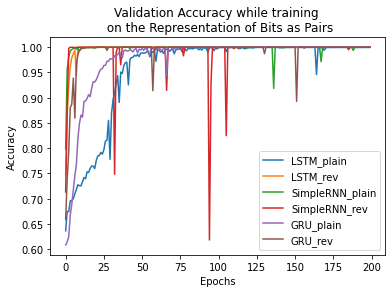

In [0]:
#Plot Training
fig, ax = plt.subplots()
for key, item in histories_bit_pairs.items():
    plt.plot(pd.DataFrame(item.history["val_accuracy"]))

ax.set_xlabel("Epochs")
ax.set_ylabel("Accuracy")
plt.legend(histories_bit_pairs.keys())
plt.title("Validation Accuracy while training \n on the Representation of Bits as Pairs")
plt.show()